#파트 A

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

### 1

In [ ]:
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import seaborn as sns
import re
from collections import Counter
from IPython.display import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import *
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go
import json

In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/kaggle_movie/movies_metadata.csv')
df_original.info()

In [ ]:
df_original

In [ ]:
df_my = df_original[['genres', 'budget', 'revenue']]
df_my

In [ ]:
df_my['genres'] = df_my['genres'].str.replace("'", '"')
df_my

In [ ]:
# JSON 데이터 추출 함수
def extract_names(json_str):
    data = json.loads(json_str)
    names = [d['name'] for d in data]
    return names

# 새로운 컬럼 생성
df_my['extracted_names'] = df_my['genres'].apply(extract_names)

df_my

In [ ]:
# 워너브라더스 인덱스 찾기
wrn_list = []
for i in range(45466):
    try:
        lis = eval(df_original['production_companies'].tolist()[i])
        if lis:
            if lis[0]['name'] == 'Warner Bros.':
                wrn_list.append(i)
    except:
        pass

wrn_series = pd.Series(wrn_list)

In [ ]:
df_my

In [ ]:
wrn_data = df_my.loc[wrn_list]
wrn_data

In [ ]:
wrn_data['revenue'] = wrn_data['revenue'].astype(int)
wrn_data['budget'] = wrn_data['budget'].astype(int)
net_profit = wrn_data['revenue'] - wrn_data['budget']
net_profit

In [ ]:
wrn_data['net_profit'] = net_profit
wrn_data

In [ ]:
wrn_data = wrn_data[wrn_data['net_profit'] != 0]
wrn_data

In [ ]:
wrn_data2 = wrn_data[['extracted_names', 'net_profit']]
wrn_data2

In [ ]:
# 분리된 데이터 저장할 리스트
data_list = []

# 행 순회하며 데이터 분리하여 리스트에 추가
for idx, row in wrn_data2.iterrows():
    extracted_names = row['extracted_names']
    net_profit = row['net_profit']
    for name in extracted_names:
        data_list.append([idx, name, net_profit])

# 분리된 데이터프레임 생성
wrn_final = pd.DataFrame(data_list, columns=['index', 'extracted_name', 'net_profit'])

wrn_final

In [ ]:
wrn_final['net_profit'] = wrn_final['net_profit'].astype(int)
wrn_final['mega_hit'] = wrn_final[wrn_final['net_profit'] >= 200000000]['net_profit']
wrn_final['mega_hit'] = wrn_final['mega_hit'].fillna(0)
wrn_final.loc[wrn_final['mega_hit'] > 0, 'mega_hit'] = True
wrn_final.loc[wrn_final['mega_hit'] == 0, 'mega_hit'] = False
wrn_final.rename(columns={'extracted_name': 'Genres'}, inplace=True)
wrn_final

In [ ]:
fig = px.scatter(wrn_final, x = 'Genres', y = 'net_profit', color='mega_hit')
fig.update_layout(
    title="Megahit Genres of Warner Bros.",
    title_x = 0.5,
    yaxis_title="net_profit($)",
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18)
)
fig.show()

- ① Adventure: 7, ② Fantasy: 6, ③ Family: 4, ④ Drama, Thriller, Action: 3

#파트 B

##예산_수익분석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
df = pd.read_csv("/content/drive/MyDrive/workspace/hw/mini1/kaggle_movie/data/movies_metadata.csv") # metadata 불러오기
wrn = df["production_companies"]


<ipython-input-49-f4d0df7acb99>:3: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



## Warner Bros. 사의 영화 가져오기

In [ ]:
df2 = df[['title','production_companies','id']]
df2

,title,production_companies,id
0,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]",862
1,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844
2,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602
3,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,31357
4,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...",11862
...,...,...,...
45461,Subdue,[],439050
45462,Century of Birthing,"[{'name': 'Sine Olivia', 'id': 19653}]",111109
45463,Betrayal,"[{'name': 'American World Pictures', 'id': 6165}]",67758
45464,Satan Triumphant,"[{'name': 'Yermoliev', 'id': 88753}]",227506


In [ ]:
# 참조: https://www.delftstack.com/ko/howto/python/python-string-to-list/
# 참조: https://blockdmask.tistory.com/437

wrn_list = []
for i in range(45466):
    try:
        lis = eval(df2['production_companies'].tolist()[i])  # eval: str 문자열을 그대로 받아서 python에 넣어줌
        if lis:
            if lis[0]['name'] == 'Warner Bros.': # 딕셔너리에서 name만 가져옴
                wrn_list.append(i)
    except:
        pass
print(wrn_list)

[2, 63, 74, 143, 150, 221, 258, 266, 339, 413, 416, 421, 452, 494, 549, 558, 885, 886, 887, 913, 921, 922, 935, 936, 946, 975, 998, 1050, 1051, 1053, 1054, 1071, 1099, 1182, 1184, 1187, 1209, 1224, 1231, 1239, 1341, 1471, 1512, 1552, 1589, 1597, 1630, 1755, 1772, 1824, 1888, 1889, 1955, 2002, 2073, 2076, 2077, 2078, 2138, 2153, 2170, 2174, 2265, 2266, 2267, 2268, 2269, 2270, 2272, 2279, 2288, 2311, 2352, 2405, 2424, 2498, 2526, 2527, 2528, 2619, 2679, 2680, 2681, 2688, 2720, 2755, 2758, 2760, 2801, 2829, 2851, 2900, 2918, 2942, 2954, 2957, 2961, 2976, 3005, 3013, 3019, 3093, 3096, 3143, 3196, 3212, 3216, 3280, 3287, 3330, 3387, 3426, 3482, 3547, 3560, 3592, 3633, 3680, 3688, 3711, 3712, 3724, 3737, 3974, 4002, 4136, 4152, 4201, 4301, 4336, 4338, 4343, 4351, 4358, 4367, 4375, 4376, 4384, 4397, 4409, 4435, 4474, 4478, 4487, 4544, 4584, 4585, 4668, 4725, 4790, 4815, 4824, 4827, 4991, 5033, 5054, 5079, 5080, 5238, 5309, 5409, 5514, 5564, 5565, 5616, 5626, 5627, 5716, 5719, 5788, 5800, 5889

In [ ]:
df2.iloc[wrn_list,:]

,title,production_companies,id
2,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602
63,Two If by Sea,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",19760
74,Big Bully,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",36929
143,The Amazing Panda Adventure,"[{'name': 'Warner Bros.', 'id': 6194}]",30765
150,Batman Forever,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",414
...,...,...,...
44640,Ali Baba Bunny,"[{'name': 'Warner Bros.', 'id': 6194}]",101503
44687,Feed the Kitty,"[{'name': 'Warner Bros.', 'id': 6194}]",83765
44689,Operation: Rabbit,"[{'name': 'Warner Bros.', 'id': 6194}]",102161
44691,Devil May Hare,"[{'name': 'Warner Bros.', 'id': 6194}]",83750


In [ ]:
dfw = df.iloc[wrn_list,:]

## 필터링

In [ ]:
# float으로 변환, 출시년도 변수 만들기
dfw['budget'] = dfw['budget'].astype(float)
dfw['revenue'] = dfw['revenue'].astype(float)
dfw['release_year'] = dfw['release_date'].str.slice(start=0,stop=4)
dfw['release_year'].astype(float)
dfw['release_year'] = pd.to_numeric(dfw['release_year'],errors='coerce')
dfw['popularity'] = pd.to_numeric(dfw['popularity'],errors='coerce')

<ipython-input-9-acff7fa9fe67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfw['budget'] = dfw['budget'].astype(float)
<ipython-input-9-acff7fa9fe67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfw['revenue'] = dfw['revenue'].astype(float)
<ipython-input-9-acff7fa9fe67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

- 1960년 이후 데이터 사용
- Budget이나 Revenue가 정확히 0인 영화는 없을 것이다 -> 제외
- 투표 수의 중간값은 10 -> 투표수 상위 50% 이상인 영화 분석

In [ ]:
dfwf = dfw.drop(dfw[(dfw['budget'] == 0)|(dfw['revenue'] == 0)|(dfw['popularity'] == 0)|(dfw['release_year'] < 1960)].index)
dfwf = dfwf[dfwf['vote_count'] > 10]
dfwf['popularity'].astype(float)
dfwf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
74,False,NaN,15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",NaN,36929,tt0115676,en,Big Bully,A writer returns to his hometown where he face...,...,2042530.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A comedy for the kid in all of us.,Big Bully,False,3.9,16.0,1996
150,False,"{'id': 120794, 'name': 'Batman Collection', 'p...",100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,414,tt0112462,en,Batman Forever,The Dark Knight of Gotham City confronts a das...,...,336529144.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Courage now, truth always...",Batman Forever,False,5.2,1529.0,1995
221,False,NaN,55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,8984,tt0109635,en,Disclosure,A computer specialist is sued for sexual haras...,...,214015089.0,123.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sex Is Power.,Disclosure,False,5.9,217.0,1994
339,False,"{'id': 3167, 'name': 'Ace Ventura Collection',...",15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 9648, 'n...",NaN,3049,tt0109040,en,Ace Ventura: Pet Detective,He's Ace Ventura: Pet Detective. Jim Carrey is...,...,107217396.0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"He's the best there is! (Actually, he's the on...",Ace Ventura: Pet Detective,False,6.4,1684.0,1994
421,False,NaN,13000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,4722,tt0106452,en,Body Snatchers,When Environmental Protection Agency inspector...,...,428868.0,87.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Imagine... you're gone and someone else is liv...,Body Snatchers,False,5.8,102.0,1993


In [ ]:
# 예산에 따른 인기도
fig = px.scatter(dfwf, x='budget', y='popularity',trendline="ols",title='popularity by budget')
fig.show()

In [ ]:
# 중간 정도 상관관계
np.corrcoef(dfwf['budget'], dfwf['popularity'])[0, 1]

0.6035574793115346

In [ ]:
# 예산에 따른 평점
fig = px.scatter(dfwf, x='budget', y='vote_average',trendline="ols",title='vote by budget')
fig.show()

In [ ]:
# 약한 상관관계
np.corrcoef(dfwf['budget'], dfwf['vote_average'])[0, 1]

0.12324237374310673

In [ ]:
# 연도에 따른 예산규모
fig = px.scatter(dfwf.sort_values('release_year'), x='release_year', y='budget',title='budget by year')
fig.show()

In [ ]:
# 연도별 흥행수익
fig = px.scatter(dfwf.sort_values('release_year'), x='release_year', y='revenue',title='revenue by year')
fig.show()

In [ ]:
# 예산에 따른 수익
fig = px.scatter(dfwf, x='budget', y='revenue',trendline="ols",title='revenue by budget')
fig.show()

In [ ]:
# 상관관계
np.corrcoef(dfwf['budget'], dfwf['revenue'])[0, 1]

0.7801962428715706

In [ ]:
# 수익률, 순이익 변수 생성
br = dfwf['revenue']/dfwf['budget']
bd = dfwf['revenue']-dfwf['budget']
dfwf['ratio'] = dfwf['revenue']/dfwf['budget']
dfwf['profit'] = dfwf['revenue']-dfwf['budget']

In [ ]:
# 고효율, 고수익의 정의
dfwf['efficient'] = dfwf['ratio'] > 10
dfwf['high_gross'] = dfwf['profit']>500000000

In [ ]:
dfwf.sort_values('ratio', ascending=False).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,release_year,ratio,profit,efficient,high_gross
1888,False,"{'id': 12263, 'name': 'The Exorcist Collection...",8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",http://theexorcist.warnerbros.com/,9552,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,...,Something almost beyond comprehension is happe...,The Exorcist,False,7.5,2046.0,1973,55.163268,4.333061e+08,True,False
1955,False,NaN,160000.0,"[{'id': 99, 'name': 'Documentary'}, {'id': 36,...",NaN,1779,tt0098213,en,Roger & Me,A documentary about the closure of General Mot...,...,NaN,Roger & Me,False,7.4,92.0,1989,41.914800,6.546368e+06,True,False
2265,False,"{'id': 9338, 'name': 'Police Academy Collectio...",4500000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9336,tt0087928,en,Police Academy,New rules enforced by the Lady Mayoress mean t...,...,What an Institution!,Police Academy,False,6.5,614.0,1984,32.488644,1.416989e+08,True,False
2755,False,NaN,2000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 12, 'name...",http://www.warnerbros.com/deliverance,10669,tt0068473,en,Deliverance,Intent on seeing the Cahulawassee River before...,...,What did happen on the Cahulawassee River?,Deliverance,False,7.2,441.0,1972,23.061177,4.412236e+07,True,False
17437,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",http://www.harrypotter.com,12445,tt1201607,en,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...",...,It all ends here.,Harry Potter and the Deathly Hallows: Part 2,False,7.9,6141.0,2011,10.736000,1.217000e+09,True,True


In [ ]:
dfwf.sort_values('profit', ascending=False).head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,release_year,ratio,profit,efficient,high_gross
17437,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",http://www.harrypotter.com,12445,tt1201607,en,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...",...,It all ends here.,Harry Potter and the Deathly Hallows: Part 2,False,7.9,6141.0,2011,10.736000,1.217000e+09,True,True
11927,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",150000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.harrypotterorderofthephoenix.com/,675,tt0373889,en,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...,...,Evil Must Be Confronted.,Harry Potter and the Order of the Phoenix,False,7.4,5633.0,2007,6.254752,7.882127e+08,False,True
16128,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.harrypotter.com,12444,tt0926084,en,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l...",...,One Way… One Fate… One Hero.,Harry Potter and the Deathly Hallows: Part 1,False,7.5,5708.0,2010,3.817223,7.043059e+08,False,True
13893,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://harrypotter.warnerbros.com/harrypottera...,767,tt0417741,en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,False,7.4,5435.0,2009,3.735837,6.839592e+08,False,True
21592,False,NaN,105000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://gravitymovie.warnerbros.com/,49047,tt1454468,en,Gravity,"Dr. Ryan Stone, a brilliant medical engineer o...",...,Don't Let Go,Gravity,False,7.3,5879.0,2013,6.822788,6.113927e+08,False,True


In [ ]:
fig = px.scatter(dfwf, x='budget', y=br,color='efficient',labels = dict(budget = "Budget(M$)",y="Income-to-cost ratio",efficient="Top 5"))
fig.update_layout(title_text='Income-to-cost ratio by budget', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y=br,color='efficient',labels = dict(release_year = "Year",y="Income-to-cost ratio",efficient="Top 5"))
fig.update_layout(title_text='Effciciency in the past', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='budget', y=bd,labels = dict(budget = "Budget(M$)",y="Net profits(B$)"))
fig.update_layout(title_text='Net profits by budget', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y=bd,color='high_gross',labels = dict(x = "Release Year",y="Net profits(B$)",high_gross="Top 5"))
fig.update_layout(title_text='Gross profit in present', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y='budget', labels = dict(release_year = "Release Year", budget="Budget(M$)"))
fig.update_layout(title_text='Budget by year', title_x=0.5)
fig.show()

## 번외

In [ ]:
# 경제성장률 반영
growth = pd.read_csv('/content/drive/MyDrive/workspace/hw/mini1/kaggle_movie/growth.csv')

In [ ]:
growth.set_index('Year')

,Annual Growth
Year,
1961,2.300000
1962,6.100000
1963,4.400000
1964,5.800000
1965,6.400000
...,...
2018,2.945385
2019,2.294439
2020,-2.767803


In [ ]:
a = growth['Annual Growth']

In [ ]:
# 누적성장률
j = 1
k = []
for i in range(0,62):
    j *= 1+ 0.01 * a[i]
    k.append(float(j))

In [ ]:
# 성장률 비율
kn = k[61]
gr = [k[i]/kn for i in range(0,62)]
gr[-5:]

[0.9298075708384855,
 0.9511414390940064,
 0.9248157224596009,
 0.9798005003057687,
 1.0]

In [ ]:
growth_rate = pd.Series(gr)

In [ ]:
growth['growth_rate'] = growth_rate
growth = growth.drop('Annual Growth', axis=1)
growth.head()

,Year,growth_rate
0,1961,0.168795
1,1962,0.179091
2,1963,0.186971
3,1964,0.197816
4,1965,0.210476


In [ ]:
# df.rename(columns = {'old_nm' : 'new_nm'}, inplace = True)
growth.rename(columns = {'Year' : 'release_year'}, inplace = True)

In [ ]:
dfwf.count() # 97

In [ ]:
dfwf = pd.merge(dfwf,growth,how ='left',left_on='release_year',right_on='release_year' )
dfwf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,release_year,ratio,profit,efficient,high_gross,growth_rate
0,False,NaN,15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",NaN,36929,tt0115676,en,Big Bully,A writer returns to his hometown where he face...,...,Big Bully,False,3.9,16.0,1996,0.136169,-12957470.0,False,False,0.551530
1,False,"{'id': 120794, 'name': 'Batman Collection', 'p...",100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,414,tt0112462,en,Batman Forever,The Dark Knight of Gotham City confronts a das...,...,Batman Forever,False,5.2,1529.0,1995,3.365291,236529144.0,False,False,0.531479
2,False,NaN,55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,8984,tt0109635,en,Disclosure,A computer specialist is sued for sexual haras...,...,Disclosure,False,5.9,217.0,1994,3.891183,159015089.0,False,False,0.517586
3,False,"{'id': 3167, 'name': 'Ace Ventura Collection',...",15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 9648, 'n...",NaN,3049,tt0109040,en,Ace Ventura: Pet Detective,He's Ace Ventura: Pet Detective. Jim Carrey is...,...,Ace Ventura: Pet Detective,False,6.4,1684.0,1994,7.147826,92217396.0,False,False,0.517586
4,False,NaN,13000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,4722,tt0106452,en,Body Snatchers,When Environmental Protection Agency inspector...,...,Body Snatchers,False,5.8,102.0,1993,0.032990,-12571132.0,False,False,0.497541


In [ ]:
dfwf['rbudget'] = dfwf['budget'] / dfwf['growth_rate']
dfwf['rrevenue'] = dfwf['revenue'] / dfwf['growth_rate']
dfwf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,release_year,ratio,profit,efficient,high_gross,growth_rate,rbudget,rrevenue
0,False,NaN,15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",NaN,36929,tt0115676,en,Big Bully,A writer returns to his hometown where he face...,...,3.9,16.0,1996,0.136169,-12957470.0,False,False,0.551530,2.719707e+07,3.703389e+06
1,False,"{'id': 120794, 'name': 'Batman Collection', 'p...",100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,414,tt0112462,en,Batman Forever,The Dark Knight of Gotham City confronts a das...,...,5.2,1529.0,1995,3.365291,236529144.0,False,False,0.531479,1.881540e+08,6.331931e+08
2,False,NaN,55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,8984,tt0109635,en,Disclosure,A computer specialist is sued for sexual haras...,...,5.9,217.0,1994,3.891183,159015089.0,False,False,0.517586,1.062625e+08,4.134867e+08
3,False,"{'id': 3167, 'name': 'Ace Ventura Collection',...",15000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 9648, 'n...",NaN,3049,tt0109040,en,Ace Ventura: Pet Detective,He's Ace Ventura: Pet Detective. Jim Carrey is...,...,6.4,1684.0,1994,7.147826,92217396.0,False,False,0.517586,2.898067e+07,2.071488e+08
4,False,NaN,13000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,4722,tt0106452,en,Body Snatchers,When Environmental Protection Agency inspector...,...,5.8,102.0,1993,0.032990,-12571132.0,False,False,0.497541,2.612848e+07,8.619744e+05


In [ ]:
# 수익률, 순이익 변수 생성
rbr = dfwf['revenue']/dfwf['budget']
rbd = dfwf['rrevenue']-dfwf['rbudget']
dfwf['rratio'] = dfwf['revenue']/dfwf['budget']
dfwf['rprofit'] = dfwf['rrevenue']-dfwf['rbudget']

In [ ]:
# 고효율, 고수익의 정의
dfwf['refficient'] = dfwf['rratio'] > 10
dfwf['rhigh_gross'] = dfwf['rprofit']>500000000

In [ ]:
dfwf.sort_values('rratio', ascending=False).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,profit,efficient,high_gross,growth_rate,rbudget,rrevenue,rratio,rprofit,refficient,rhigh_gross
17,False,"{'id': 12263, 'name': 'The Exorcist Collection...",8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",http://theexorcist.warnerbros.com/,9552,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,...,4.333061e+08,True,False,0.284345,2.813484e+07,1.552010e+09,55.163268,1.523875e+09,True,True
19,False,NaN,160000.0,"[{'id': 99, 'name': 'Documentary'}, {'id': 36,...",NaN,1779,tt0098213,en,Roger & Me,A documentary about the closure of General Mot...,...,6.546368e+06,True,False,0.459580,3.481437e+05,1.459237e+07,41.914800,1.424423e+07,True,False
22,False,"{'id': 9338, 'name': 'Police Academy Collectio...",4500000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9336,tt0087928,en,Police Academy,New rules enforced by the Lady Mayoress mean t...,...,1.416989e+08,True,False,0.381620,1.179184e+07,3.831008e+08,32.488644,3.713090e+08,True,False
31,False,NaN,2000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 12, 'name...",http://www.warnerbros.com/deliverance,10669,tt0068473,en,Deliverance,Intent on seeing the Cahulawassee River before...,...,4.412236e+07,True,False,0.269150,7.430813e+06,1.713633e+08,23.061177,1.639325e+08,True,False
84,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",http://www.harrypotter.com,12445,tt1201607,en,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...",...,1.217000e+09,True,True,0.794025,1.574258e+08,1.690124e+09,10.736000,1.532698e+09,True,True


In [ ]:
dfwf.sort_values('rprofit', ascending=False).head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,profit,efficient,high_gross,growth_rate,rbudget,rrevenue,rratio,rprofit,refficient,rhigh_gross
84,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",http://www.harrypotter.com,12445,tt1201607,en,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...",...,1.217000e+09,True,True,0.794025,1.574258e+08,1.690124e+09,10.736000,1.532698e+09,True,True
17,False,"{'id': 12263, 'name': 'The Exorcist Collection...",8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",http://theexorcist.warnerbros.com/,9552,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,...,4.333061e+08,True,False,0.284345,2.813484e+07,1.552010e+09,55.163268,1.523875e+09,True,True
74,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",150000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.harrypotterorderofthephoenix.com/,675,tt0373889,en,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...,...,7.882127e+08,False,True,0.780651,1.921473e+08,1.201834e+09,6.254752,1.009687e+09,False,True
82,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.harrypotter.com,12444,tt0926084,en,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l...",...,7.043059e+08,False,True,0.781906,3.197315e+08,1.220487e+09,3.817223,9.007552e+08,False,True
78,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://harrypotter.warnerbros.com/harrypottera...,767,tt0417741,en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",...,6.839592e+08,False,True,0.761284,3.283926e+08,1.226821e+09,3.735837,8.984285e+08,False,True


In [ ]:
fig = px.scatter(dfwf, x='rbudget', y=br,color='refficient',labels = dict(budget = "rBudget(M$)",y="Income-to-cost ratio",efficient="Top 5"))
fig.update_layout(title_text='Income-to-cost ratio by rbudget', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y=rbr,color='refficient',labels = dict(release_year = "Year",y="Income-to-cost ratio",efficient="Top 5"))
fig.update_layout(title_text='Effciciency in the past', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='rbudget', y=rbd,labels = dict(budget = "Budget(M$)",y="Net rprofits(B$)"))
fig.update_layout(title_text='Net rprofits by budget', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y=bd,color='rhigh_gross',labels = dict(x = "Release Year",y="Net profits(B$)",high_gross="Top 5"))
fig.update_layout(title_text='rGross profit in present', title_x=0.5)
fig.show()

In [ ]:
fig = px.scatter(dfwf, x='release_year', y='rbudget', labels = dict(release_year = "Release Year", budget="rBudget(M$)"))
fig.update_layout(title_text='rBudget by year', title_x=0.5)
fig.show()

#파트 C

## keywords 전체 WordCloud

In [ ]:
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import seaborn as sns
import re
from collections import Counter
from IPython.display import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import *
from wordcloud import WordCloud, STOPWORDS

In [ ]:
df_kws = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_movie/keywords.csv')
df_kws.info()
df_kws

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [ ]:
Ser_kws = df_kws['keywords']
li_kws = list(Ser_kws)

In [ ]:
## [[간이 테스트용]] 데이터 전처리 (불필요한 특수문자, 숫자, 'id', 'name' 등 제거)

test1 = re.sub(r'[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’\{\}·0-9]', '', li_kws[0])

test2 = test1.replace('id', '').replace('name', '')

# print(test2)

In [ ]:
real_test = ''

for kws in li_kws:
    real_test += re.sub(r'[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’\{\}·0-9]', '', kws)  ## 특수문자 제거

real_test = real_test.replace('id', '').replace('name', '').replace(' on ', '').replace('film', '').replace(' of ', '').replace(' the ', '') ## 'id', 'name', 'on', 'flim' 제거

In [ ]:
real_test = real_test.split() ## ' ' 기준으로 나눈다

counter = Counter(real_test) ## 등장 횟수 카운트

print(counter)



Counter({'woman': 3599, 'director': 3211, 'relationship': 1946, 'independent': 1930, 'murder': 1649, 'nudity': 1428, 'love': 1421, 'war': 1343, 'sex': 1069, 'new': 1065, 'comedy': 1061, 'female': 999, 'police': 918, 'musical': 916, 'family': 906, 'and': 878, 'movie': 873, 'school': 856, 'basednovel': 835, 'drug': 826, 'violence': 793, 'world': 686, 'man': 666, 'revenge': 655, 'killer': 637, 'biography': 633, 'car': 620, 'brother': 602, 'death': 602, 'child': 600, 'suspense': 590, 'father': 579, 'sport': 573, 'friendship': 562, 'gay': 559, 'music': 557, 'york': 554, 'prison': 551, 'secret': 526, 'marriage': 503, 'alien': 500, 'space': 487, 'in': 485, 'american': 483, 'daughter': 482, 'noir': 473, 'life': 469, 'mother': 468, 'england': 467, 's': 461, 'high': 459, 'suice': 455, 'teenager': 455, 'sister': 443, 'duringcreditsstinger': 440, 'monster': 440, 'sequel': 440, 'ii': 423, 'horror': 399, 'rape': 396, 'son': 392, 'male': 392, 'city': 391, 'martial': 381, 'arts': 372, 'standup': 370, 

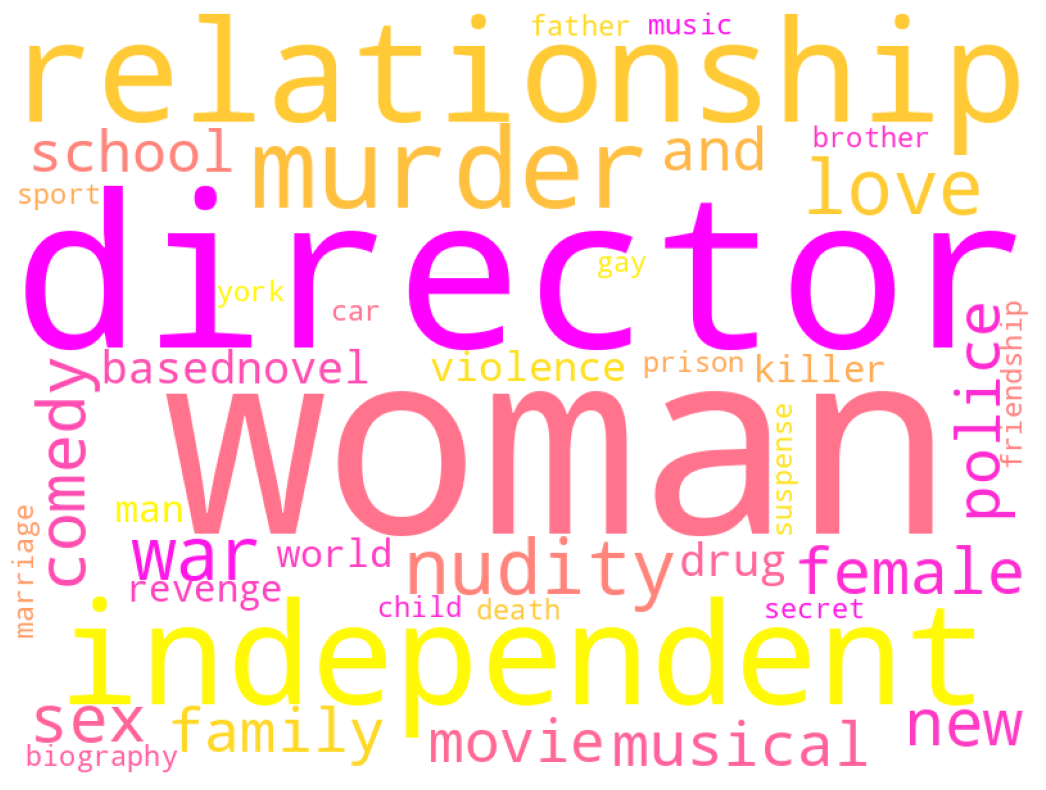

In [ ]:
palettes = ['spring']

wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'white', #배경색
                      width = 800,
                      max_words=40, ## 단어 수
                      colormap = palettes[0],
                      height = 600).generate_from_frequencies(counter)

plt.figure(figsize = (15, 10)) # (가로인치, 세로인치)
plt.axis("off") # 축눈금 제거
plt.imshow(wordcloud) # 이미지가 표시되도록
plt.show() # 최종 출력문

##Mini1_WordCloud(Wnb)

In [ ]:
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import seaborn as sns
import re
from collections import Counter
from IPython.display import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import *
from wordcloud import WordCloud, STOPWORDS

In [ ]:
df_meta = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_movie/movies_metadata.csv')
df_id_com = df_meta[['id', 'production_companies']]
df_id_com

<ipython-input-3-492082c9415a>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_movie/movies_metadata.csv')


,id,production_companies
0,862,"[{'name': 'Pixar Animation Studios', 'id': 3}]"
1,8844,"[{'name': 'TriStar Pictures', 'id': 559}, {'na..."
2,15602,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
3,31357,[{'name': 'Twentieth Century Fox Film Corporat...
4,11862,"[{'name': 'Sandollar Productions', 'id': 5842}..."
...,...,...
45461,439050,[]
45462,111109,"[{'name': 'Sine Olivia', 'id': 19653}]"
45463,67758,"[{'name': 'American World Pictures', 'id': 6165}]"
45464,227506,"[{'name': 'Yermoliev', 'id': 88753}]"


In [ ]:
df_kws_wnb = pd.read_csv('/content/drive/MyDrive/datasets/kaggle_movie/keywords.csv')
df_kws_wnb.info()
df_kws_wnb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [ ]:
Ser_kws_wnb = df_kws_wnb['keywords']
li_kws_wnb = list(Ser_kws_wnb)

In [ ]:
## 메타데이터에서 "워너브라더스" 인덱스_리스트 추출

wrn_list = []
for i in range(45466):
    try:
        lis = eval(df_meta['production_companies'].tolist()[i])
        if lis:
            if lis[0]['name'] == 'Warner Bros.':
                wrn_list.append(i)
    except:
        pass
len(wrn_list)
# print(wrn_list)


757

In [ ]:
id_li = []
for idx in wrn_list:
    id_li.append(df_id_com.loc[idx])

id_li

dic_id = pd.DataFrame(id_li)
dic_id

,id,production_companies
2,15602,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
63,19760,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
74,36929,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
143,30765,"[{'name': 'Warner Bros.', 'id': 6194}]"
150,414,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
...,...,...
44640,101503,"[{'name': 'Warner Bros.', 'id': 6194}]"
44687,83765,"[{'name': 'Warner Bros.', 'id': 6194}]"
44689,102161,"[{'name': 'Warner Bros.', 'id': 6194}]"
44691,83750,"[{'name': 'Warner Bros.', 'id': 6194}]"


In [ ]:
dic_id_str = dic_id.astype({'id':'int'})

In [ ]:
df_comb_data = pd.merge(dic_id_str, df_kws_wnb, on = 'id')
df_comb_data

,id,production_companies,keywords
0,15602,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
1,19760,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 2041, 'name': 'island'}, {'id': 5918, ..."
2,36929,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 10624, 'name': 'bully'}]"
3,30765,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'id': 478, 'name': 'china'}, {'id': 8531, 'n..."
4,414,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'id': 483, 'name': 'riddle'}, {'id': 849, 'n..."
...,...,...,...
756,101503,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'id': 9981, 'name': 'bugs bunny'}, {'id': 18..."
757,83765,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'id': 15162, 'name': 'dog'}, {'id': 156143, ..."
758,102161,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'id': 9981, 'name': 'bugs bunny'}, {'id': 15..."
759,83750,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'id': 9981, 'name': 'bugs bunny'}, {'id': 18..."


In [ ]:
Ser_kws_wnb = df_comb_data['keywords']
li_kws_wnb = list(Ser_kws_wnb)

In [ ]:
real_test_wnb = ''

for kws_wnb in li_kws_wnb:
    real_test_wnb += re.sub(r'[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’\{\}·0-9]', '', kws_wnb)  ## 특수문자 제거

real_test_wnb = real_test_wnb.replace('id', '').replace('name', '').replace(' on ', '').replace('film', '').replace(' of ', '').replace(' the ', '') ## 'id', 'name', 'on', 'flim' 제거

In [ ]:
real_test_wnb = real_test_wnb.split() ## ' ' 기준으로 나눈다

counter_wnb = Counter(real_test_wnb) ## 등장 횟수 카운트

print(counter_wnb)

Counter({'noir': 47, 'murder': 43, 'war': 43, 'musical': 40, 'police': 31, 'love': 30, 'new': 29, 'prison': 25, 'woman': 24, 'gangster': 24, 'world': 23, 'american': 20, 'marriage': 20, 'man': 19, 'child': 19, 'york': 19, 'school': 18, 'relationship': 18, 'city': 17, 'life': 17, 'detective': 17, 'biography': 17, 'death': 15, 'family': 15, 'movie': 15, 'director': 14, 'escape': 14, 'sport': 14, 'revenge': 14, 'town': 14, 'ii': 14, 'and': 13, 'mother': 13, 'island': 12, 'private': 12, 'girl': 12, 'train': 12, 'crime': 12, 'gang': 12, 'robbery': 12, 'basednovel': 11, 'england': 11, 'drug': 11, 'wedding': 11, 'wife': 11, 'small': 11, 'music': 11, 'fight': 10, 'suspense': 10, 'car': 10, 'lawyer': 10, 'singer': 10, 'precode': 10, 'dead': 9, 'us': 9, 'doctor': 9, 'cop': 9, 'spy': 9, 'black': 9, 'brother': 9, 'show': 9, 'agent': 9, 'classic': 9, 'husband': 9, 'pilot': 9, 'fbi': 9, 'army': 9, 'boat': 9, 'duck': 9, 'bugs': 9, 'bunny': 9, 'duringcreditsstinger': 8, 'old': 8, 'criminal': 8, 'figur

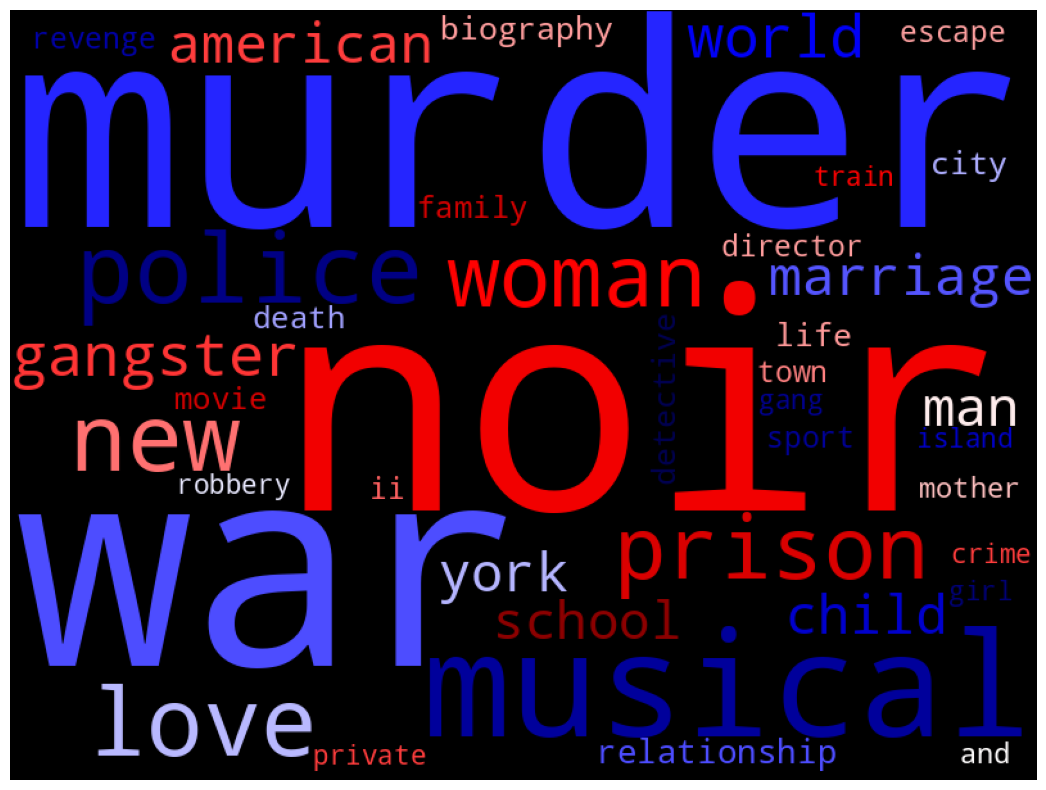

In [ ]:
palettes = ['seismic']

wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'black', #배경색
                      width = 800,
                      max_words=40, ## 단어 수
                      colormap = palettes[0],
                      height = 600).generate_from_frequencies(counter_wnb)

plt.figure(figsize = (15, 10)) # (가로인치, 세로인치)
plt.axis("off") # 축눈금 제거
plt.imshow(wordcloud) # 이미지가 표시되도록
plt.show() # 최종 출력문

#파트 D

##워너 브라더스만 추출

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")
df.info()


<ipython-input-16-04a8cdda8784>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
df2 = df[['title','production_companies','id']]
df2

,title,production_companies,id
0,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]",862
1,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844
2,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602
3,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,31357
4,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...",11862
...,...,...,...
45461,Subdue,[],439050
45462,Century of Birthing,"[{'name': 'Sine Olivia', 'id': 19653}]",111109
45463,Betrayal,"[{'name': 'American World Pictures', 'id': 6165}]",67758
45464,Satan Triumphant,"[{'name': 'Yermoliev', 'id': 88753}]",227506


In [ ]:
wrn_list = []
for i in range(45466):
    try:
        lis = eval(df2['production_companies'].tolist()[i])
        if lis:
            if lis[0]['name'] == 'Warner Bros.':
                wrn_list.append(i)
    except:
        pass


# print(wrn_list)

df2 = df.loc[wrn_list]

df2[['title','popularity','release_date']]

,title,popularity,release_date
0,Toy Story,21.946943,1995-10-30
1,Jumanji,17.015539,1995-12-15
2,Grumpier Old Men,11.7129,1995-12-22
3,Waiting to Exhale,3.859495,1995-12-22
4,Father of the Bride Part II,8.387519,1995-02-10
...,...,...,...
752,Quartier Mozart,0.011938,1992-05-26
753,Touki Bouki,0.043903,1973-07-01
754,God's Gift,0.049573,1982-01-01
755,Spirits of the Dead,1.794298,1968-05-16


##파트4_과정_1

df2 = df['release_date'].dropna()를 date 오브젝트 만들어 새로운 데이터 프레임에


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")
df.loc[707]


<ipython-input-2-bda50974f783>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")


adult                                                                False
belongs_to_collection                                                  NaN
budget                                                                   0
genres                   [{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...
homepage                                                               NaN
id                                                                  131232
imdb_id                                                          tt0333373
original_language                                                       en
original_title                                                   Due Amici
overview                 Two Sicilian friends, Nunzio and Pino, share t...
popularity                                                        0.003949
poster_path                               /jo4n8M8EHedIuatB39C8EEmJBH8.jpg
production_companies                                                    []
production_countries     

In [ ]:
df2 = df[['title','release_date','id']]
# df2.dropna(inplace=True)


In [ ]:
# for i in range(45466):
#     try:
#         list = df2['release_date'].tolist()
#         ls = pd.to_datetime(list)
#     except:
#         df2.drop(i,axis=0)

bool_list = [False if type(i) == 'float' else True for i in df2['release_date'].tolist()]
df3 = df2[bool_list]

list = df3['release_date'].tolist()
ls = pd.to_datetime(list)


df2['개봉일(datetime)'] = ls
df2['감독명'] = None
release_dt = df2[df2['개봉일(datetime)'] > '2000-01-01']
index_list = release_dt.loc[:].index #사용하는 데이터의 인덱스
# len(index_list.tolist())
release_dt.tail(230)


ValueError: ignored

In [ ]:
df_crew = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle_movie/credits.csv')

# x = eval(df_crew['crew'][2114])  #딕셔너리인 척 하는 문자열
# print(x)
# for i in x:
#     if i['job'] == 'Director':
#         print(i['name'])


for k in index_list:
    lis = eval(df_crew['crew'][k])
    for i in lis:
        if i['job'] == 'Director':
            release_dt['감독명'].loc[k] = i['name']
        break


release_dt

# dirc = []

# for k in index_list:
#     lis = eval(df_crew['crew'][k])
#     for i in lis:
#         if i['job'] == 'Director':
#             dirc.append(i['name'])
#             break

# print(dirc)


<ipython-input-31-208730aa5b92>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  release_dt['감독명'].loc[k] = i['name']


,title,release_date,id,개봉일(datetime),감독명
707,Two Friends,2002-03-20,131232,2002-03-20,Francesco Sframeli
868,Venice,2010-05-25,79782,2010-05-25,Jan Jakub Kolski
1081,The Sleepover,2013-10-12,141210,2013-10-12,Chris Cullari
2114,The Farmer's Wife,2012-06-20,143750,2012-06-20,None
2564,A Place at the Table,2012-03-22,84198,2012-03-22,Kristi Jacobson
...,...,...,...,...,...
45457,Shadow of the Blair Witch,2000-10-22,390959,2000-10-22,Georges Méliès
45458,The Burkittsville 7,2000-10-03,289923,2000-10-03,Georges Méliès
45462,Century of Birthing,2011-11-17,111109,2011-11-17,None
45463,Betrayal,2003-08-01,67758,2003-08-01,None


In [ ]:
df_crew['crew'][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [ ]:
!head -n 3 /proc/meminfo

MemTotal:       13294264 kB
MemFree:         8727000 kB
MemAvailable:   11866264 kB


In [ ]:
df_rating = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/ratings.csv")
# dff.iloc[:,2]
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [ ]:
print(lis)

[{'credit_id': '52fe4284c3a36847f8024f49', 'department': 'Directing', 'gender': 2, 'id': 7879, 'job': 'Director', 'name': 'John Lasseter', 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}, {'credit_id': '52fe4284c3a36847f8024f4f', 'department': 'Writing', 'gender': 2, 'id': 12891, 'job': 'Screenplay', 'name': 'Joss Whedon', 'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'}, {'credit_id': '52fe4284c3a36847f8024f55', 'department': 'Writing', 'gender': 2, 'id': 7, 'job': 'Screenplay', 'name': 'Andrew Stanton', 'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'}, {'credit_id': '52fe4284c3a36847f8024f5b', 'department': 'Writing', 'gender': 2, 'id': 12892, 'job': 'Screenplay', 'name': 'Joel Cohen', 'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'}, {'credit_id': '52fe4284c3a36847f8024f61', 'department': 'Writing', 'gender': 0, 'id': 12893, 'job': 'Screenplay', 'name': 'Alec Sokolow', 'profile_path': '/v79vlRYi94BZUQnkkyznbGUZLjT.jpg'}, {'credit_id': '52fe4284c3a36847f8024f67', 'depart

##파트4_과정_2

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")
df.loc[707]

<ipython-input-78-bda50974f783>:7: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



adult                                                                False
belongs_to_collection                                                  NaN
budget                                                                   0
genres                   [{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...
homepage                                                               NaN
id                                                                  131232
imdb_id                                                          tt0333373
original_language                                                       en
original_title                                                   Due Amici
overview                 Two Sicilian friends, Nunzio and Pino, share t...
popularity                                                        0.003949
poster_path                               /jo4n8M8EHedIuatB39C8EEmJBH8.jpg
production_companies                                                    []
production_countries     

In [ ]:
df2 = df[['title','production_companies','id']]
df2

,title,production_companies,id
0,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]",862
1,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",8844
2,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602
3,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,31357
4,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...",11862
...,...,...,...
45461,Subdue,[],439050
45462,Century of Birthing,"[{'name': 'Sine Olivia', 'id': 19653}]",111109
45463,Betrayal,"[{'name': 'American World Pictures', 'id': 6165}]",67758
45464,Satan Triumphant,"[{'name': 'Yermoliev', 'id': 88753}]",227506


In [ ]:
wrn_list = []
for i in range(45466):
    try:
        lis = eval(df2['production_companies'].tolist()[i])
        if lis:
            if lis[0]['name'] == 'Warner Bros.':
                wrn_list.append(i)
    except:
        pass


# print(wrn_list)

df2 = df.loc[wrn_list]

df3 = df2[['title','release_date','production_companies','id']]
df3 = df3.rename(columns={'id':'movieId'})
df3['감독명'] = None
df3

,title,release_date,production_companies,movieId,감독명
2,Grumpier Old Men,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,None
63,Two If by Sea,1996-01-12,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",19760,None
74,Big Bully,1996-01-26,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",36929,None
143,The Amazing Panda Adventure,1995-08-25,"[{'name': 'Warner Bros.', 'id': 6194}]",30765,None
150,Batman Forever,1995-06-16,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",414,None
...,...,...,...,...,...
44640,Ali Baba Bunny,1957-02-09,"[{'name': 'Warner Bros.', 'id': 6194}]",101503,None
44687,Feed the Kitty,1952-02-02,"[{'name': 'Warner Bros.', 'id': 6194}]",83765,None
44689,Operation: Rabbit,1952-01-19,"[{'name': 'Warner Bros.', 'id': 6194}]",102161,None
44691,Devil May Hare,1954-06-19,"[{'name': 'Warner Bros.', 'id': 6194}]",83750,None


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df_crew = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle_movie/credits.csv')

# x = eval(df_crew['crew'][2114])  #딕셔너리인 척 하는 문자열
# print(x)
# for i in x:
#     if i['job'] == 'Director':
#         print(i['name'])

count = 0
for k in wrn_list:
    lis = eval(df_crew['crew'][k])
    for i in lis:
        if i['job'] == 'Director':
            df3['감독명'].loc[k] = i['name']
            count += 1
        break


df3 = df3.astype({'movieId':'int'})
df3

,title,release_date,production_companies,movieId,감독명
2,Grumpier Old Men,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,Howard Deutch
63,Two If by Sea,1996-01-12,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",19760,Bill Bennett
74,Big Bully,1996-01-26,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",36929,Steve Miner
143,The Amazing Panda Adventure,1995-08-25,"[{'name': 'Warner Bros.', 'id': 6194}]",30765,Christopher Cain
150,Batman Forever,1995-06-16,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",414,Joel Schumacher
...,...,...,...,...,...
44640,Ali Baba Bunny,1957-02-09,"[{'name': 'Warner Bros.', 'id': 6194}]",101503,None
44687,Feed the Kitty,1952-02-02,"[{'name': 'Warner Bros.', 'id': 6194}]",83765,None
44689,Operation: Rabbit,1952-01-19,"[{'name': 'Warner Bros.', 'id': 6194}]",102161,Werner Herzog
44691,Devil May Hare,1954-06-19,"[{'name': 'Warner Bros.', 'id': 6194}]",83750,Werner Herzog


In [ ]:
df4 = df3.dropna()
df4_list = df4.index.tolist()
df4

,title,release_date,production_companies,movieId,감독명
2,Grumpier Old Men,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",15602,Howard Deutch
63,Two If by Sea,1996-01-12,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",19760,Bill Bennett
74,Big Bully,1996-01-26,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",36929,Steve Miner
143,The Amazing Panda Adventure,1995-08-25,"[{'name': 'Warner Bros.', 'id': 6194}]",30765,Christopher Cain
150,Batman Forever,1995-06-16,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",414,Joel Schumacher
...,...,...,...,...,...
43762,Desirable,1934-09-08,"[{'name': 'Warner Bros.', 'id': 6194}]",157898,Aleksei Korenev
44320,The Prisoner of Second Avenue,1975-03-14,"[{'name': 'Warner Bros.', 'id': 6194}]",19221,Charles Nemes
44625,Malcolm X,1972-05-24,"[{'name': 'Warner Bros.', 'id': 6194}]",46898,Rob Epstein
44689,Operation: Rabbit,1952-01-19,"[{'name': 'Warner Bros.', 'id': 6194}]",102161,Werner Herzog


In [ ]:
df_rating = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/ratings.csv")
df_rating.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [ ]:
df_rating = df_rating[['movieId','rating']]
dd = df_rating.groupby('movieId').mean()
dd['movieId'] = dd.index
# dd = dd.reset_index(drop=True)
dd[dd['movieId'] == 414]
dd

,rating,movieId
movieId,,
1,3.888157,1
2,3.236953,2
3,3.175550,3
4,2.875713,4
5,3.079565,5
...,...,...
176267,4.000000,176267
176269,3.500000,176269
176271,5.000000,176271


In [ ]:
df_comb_data = pd.merge(df4, dd, on = 'movieId')
df_comb_data = df_comb_data.astype({'release_date':'datetime64'})

df_comb_data['release_date(month)'] = df_comb_data['release_date'].dt.month
df_comb_data
# df_comb_data #평점을 가지고 있는 워너 브라더스의 영화 id, 감독명


,title,release_date,production_companies,movieId,감독명,rating,release_date(month)
0,Batman Forever,1995-06-16,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",414,Joel Schumacher,2.615926,6
1,Disclosure,1994-12-09,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",8984,Barry Levinson,3.310193,12
2,Ace Ventura: Pet Detective,1994-02-04,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",3049,Tom Shadyac,3.094650,2
3,Body Snatchers,1993-06-09,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",4722,Abel Ferrara,3.416230,6
4,The Fugitive,1993-08-06,"[{'name': 'Warner Bros.', 'id': 6194}]",5503,Andrew Davis,3.319728,8
...,...,...,...,...,...,...,...
56,The Silk Express,1933-06-01,"[{'name': 'Warner Bros.', 'id': 6194}]",159215,Michael Pataki,3.000000,6
57,The Famous and the Dead,2009-09-25,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",73919,Francis Mankiewicz,3.600000,9
58,Little Big Shot,1935-09-07,"[{'name': 'Warner Bros.', 'id': 6194}]",106495,Alan Gibson,2.666667,9
59,Song of the Saddle,1936-02-28,"[{'name': 'Warner Bros.', 'id': 6194}]",134238,Henri Decoin,3.000000,2


In [ ]:
import plotly.express as px

df_plot = df_comb_data
fig = px.bar(df_plot, x="release_date(month)", y="rating")
fig.show()

##파트4_과정_월별 영화 수

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")
df.loc[707]

<ipython-input-2-bda50974f783>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")


adult                                                                False
belongs_to_collection                                                  NaN
budget                                                                   0
genres                   [{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...
homepage                                                               NaN
id                                                                  131232
imdb_id                                                          tt0333373
original_language                                                       en
original_title                                                   Due Amici
overview                 Two Sicilian friends, Nunzio and Pino, share t...
popularity                                                        0.003949
poster_path                               /jo4n8M8EHedIuatB39C8EEmJBH8.jpg
production_companies                                                    []
production_countries     

In [ ]:
df2 = df[['genres','release_date']]
df2.dropna(inplace=True)
df2

<ipython-input-3-3ae91ad55bc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(inplace=True)


,genres,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10
...,...,...
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1991-05-13
45462,"[{'id': 18, 'name': 'Drama'}]",2011-11-17
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",2003-08-01
45464,[],1917-10-21


In [ ]:
bool_list = [True if '-' in i  else False for i in df2['release_date'].tolist()]
df3 = df2[bool_list]

lis = df3['release_date'].tolist()
ls = pd.to_datetime(lis)


df3['개봉일(datetime)'] = ls

df3['개봉일(month)'] = df3['개봉일(datetime)'].dt.month
df3['count'] = 1
df4 = df3.groupby('개봉일(month)').sum()
df4

<ipython-input-16-1e168953a47b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['개봉일(datetime)'] = ls
<ipython-input-16-1e168953a47b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['개봉일(month)'] = df3['개봉일(datetime)'].dt.month
<ipython-input-16-1e168953a47b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,count
개봉일(month),
1,5912
2,3032
3,3553
4,3453
5,3339
6,3153
7,2640
8,3394
9,4838


##월별 영화 갯수

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")
df.loc[707]

<ipython-input-10-bda50974f783>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle_movie/movies_metadata.csv")


adult                                                                False
belongs_to_collection                                                  NaN
budget                                                                   0
genres                   [{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...
homepage                                                               NaN
id                                                                  131232
imdb_id                                                          tt0333373
original_language                                                       en
original_title                                                   Due Amici
overview                 Two Sicilian friends, Nunzio and Pino, share t...
popularity                                                        0.003949
poster_path                               /jo4n8M8EHedIuatB39C8EEmJBH8.jpg
production_companies                                                    []
production_countries     

In [ ]:
df2 = df[['genres','release_date']]
df2.dropna(inplace=True)
df2

<ipython-input-11-3ae91ad55bc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(inplace=True)


,genres,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10
...,...,...
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1991-05-13
45462,"[{'id': 18, 'name': 'Drama'}]",2011-11-17
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",2003-08-01
45464,[],1917-10-21


In [ ]:
df2['genres'] = df2['genres'].str.replace("'", '"')
df2

<ipython-input-12-2219176cd301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['genres'] = df2['genres'].str.replace("'", '"')


,genres,release_date
0,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",1995-10-30
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",1995-12-15
2,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ...",1995-12-22
3,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",1995-12-22
4,"[{""id"": 35, ""name"": ""Comedy""}]",1995-02-10
...,...,...
45460,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",1991-05-13
45462,"[{""id"": 18, ""name"": ""Drama""}]",2011-11-17
45463,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",2003-08-01
45464,[],1917-10-21


In [ ]:
import json
# JSON 데이터 추출 함수
def extract_names(json_str):
    data = json.loads(json_str)
    names = [d['name'] for d in data]
    return names

# 새로운 컬럼 생성
df2['extracted_names'] = df2['genres'].apply(extract_names)

df2

<ipython-input-13-706debc7e347>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['extracted_names'] = df2['genres'].apply(extract_names)


,genres,release_date,extracted_names
0,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",1995-10-30,"[Animation, Comedy, Family]"
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",1995-12-15,"[Adventure, Fantasy, Family]"
2,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ...",1995-12-22,"[Romance, Comedy]"
3,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",1995-12-22,"[Comedy, Drama, Romance]"
4,"[{""id"": 35, ""name"": ""Comedy""}]",1995-02-10,[Comedy]
...,...,...,...
45460,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",1991-05-13,"[Drama, Action, Romance]"
45462,"[{""id"": 18, ""name"": ""Drama""}]",2011-11-17,[Drama]
45463,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",2003-08-01,"[Action, Drama, Thriller]"
45464,[],1917-10-21,[]


In [ ]:
bool_list = [True if '-' in i  else False for i in df2['release_date'].tolist()]
df3 = df2[bool_list]

lis = df3['release_date'].tolist()
ls = pd.to_datetime(lis)


df3['개봉일(datetime)'] = ls

df3['개봉일(month)'] = df3['개봉일(datetime)'].dt.month
df4 = df3[['개봉일(month)','extracted_names']]
df4


<ipython-input-14-a7ef575517e6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['개봉일(datetime)'] = ls
<ipython-input-14-a7ef575517e6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['개봉일(month)'] = df3['개봉일(datetime)'].dt.month


,개봉일(month),extracted_names
0,10,"[Animation, Comedy, Family]"
1,12,"[Adventure, Fantasy, Family]"
2,12,"[Romance, Comedy]"
3,12,"[Comedy, Drama, Romance]"
4,2,[Comedy]
...,...,...
45460,5,"[Drama, Action, Romance]"
45462,11,[Drama]
45463,8,"[Action, Drama, Thriller]"
45464,10,[]


In [ ]:
dic = {'상반기':{}, '하반기':{}}
for row in df4.iterrows():
    # print(row[1].values.tolist())
    m, g_list = row[1].values.tolist()
    if m < 7:
        m = '상반기'
    else:
        m = '하반기'

    for g in g_list:
        if g in dic[m]:
            dic[m][g] += 1
        else:
            dic[m][g] = 1

df_g = pd.DataFrame(dic)


In [ ]:
dic = {i:{} for i in range(1, 13)}
for row in df4.iterrows():
    # print(row[1].values.tolist())
    m, g_list = row[1].values.tolist()
    for g in g_list:
        if g in dic[m]:
            dic[m][g] += 1
        else:
            dic[m][g] = 1


df_g = pd.DataFrame(dic)
df_g = df_g.loc[['Drama','Thriller','Action','Adventure','Family','Fantasy']]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


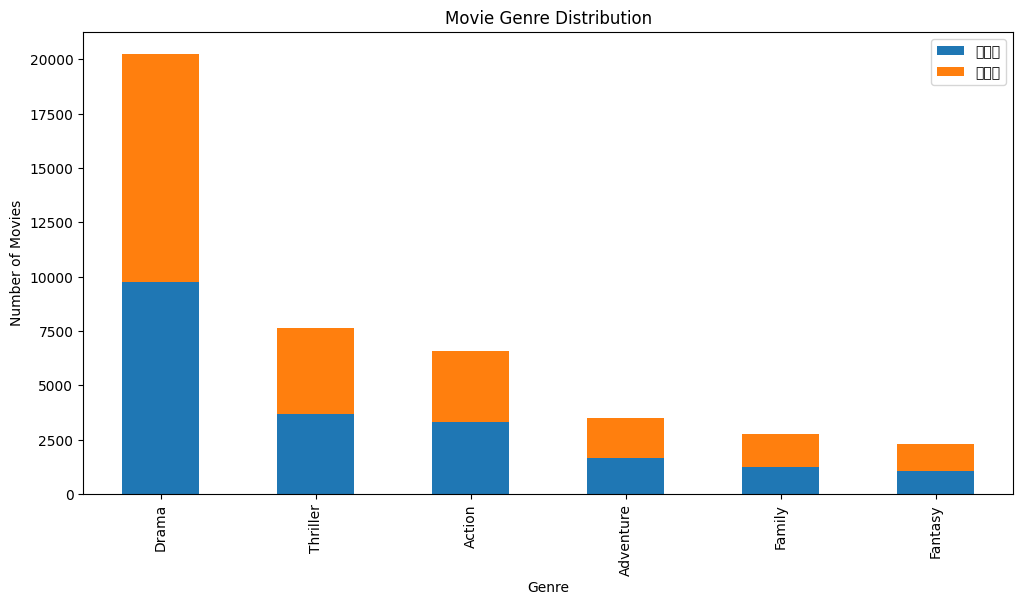

In [ ]:
import matplotlib.pyplot as plt

df_g['상반기'] = df_g[[1,2,3,4,5,6]].sum(axis=1)
df_g['하반기'] = df_g[[7,8,9,10,11,12]].sum(axis=1)
df_g['Genre'] = df_g.index
df_g = df_g[['상반기','하반기','Genre']]


df_g.plot(kind='bar', x='Genre', stacked=True, figsize=(12, 6))

# 그래프 제목과 축 레이블 설정
plt.title('Movie Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# 범례 표시
plt.legend(loc='upper right')

# 그래프 출력
plt.show()